# TODO

- you need plots


In [2]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

import matplotlib.pyplot as plt

In [3]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_2.pkl', 'rb') as file:
    bodies_df_exposure = pickle.load(file)

['all_rural',
 'all_formal',
 'all_public',
 'all_militarized',
 'all_urban',
 'all_privat']

In [10]:
# pre

list_of_features_mean = [feature for feature in bodies_df_exposure.columns if 'mean' in feature] 
list_of_ra_features = [feature for feature in bodies_df_exposure.columns if 'all' in feature] 

list_of_features = list_of_features_mean + list_of_ra_features

df_sub = bodies_df_exposure[list_of_features + ['log_best', 'tce', 'tsce', 'publication', 'month_id', 'gid']].copy()
df_sub = df_sub[df_sub['person_mean'] != 0] # no people, no entry
df_sub[['Published', 'Raw', 'Submitted']] = pd.get_dummies(df_sub[['publication']])
df_sub.drop(columns= 'publication', inplace= True)
df_sub.dropna(inplace= True)

# for FE
df_sub.set_index(['gid', 'month_id'], inplace = True)

df_sub['intPubBest'] = df_sub['Published'] * df_sub['log_best']
df_sub['intPubTce'] = df_sub['Published'] * df_sub['tce']
df_sub['intPubTsce'] = df_sub['Published'] * df_sub['tsce']


In [11]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7340
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.5706
Time:,03:11:47,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,5824.4


In [12]:
X = df_sub.loc[:,['uniformed_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3406
Estimator:,PanelOLS,R-squared (Between):,0.9168
No. Observations:,126548,R-squared (Within):,0.3528
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.4454
Time:,03:11:49,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.267e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1685.6


In [13]:
X = df_sub.loc[:,['all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3708
Estimator:,PanelOLS,R-squared (Between):,0.7200
No. Observations:,126548,R-squared (Within):,0.3950
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.5912
Time:,03:11:56,Log-likelihood,-1.346e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.727e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1823.9


In [14]:
X = df_sub.loc[:,['all_militarized','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3402
Estimator:,PanelOLS,R-squared (Between):,0.9178
No. Observations:,126548,R-squared (Within):,0.3525
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.4465
Time:,03:12:23,Log-likelihood,-1.742e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.26e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1660.1


In [5]:
X = df_sub.loc[:,['log_best']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,6.96e-06
Estimator:,PanelOLS,R-squared (Between):,-0.0097
No. Observations:,126548,R-squared (Within):,-0.0008
Date:,"Fri, Oct 07 2022",R-squared (Overall):,-0.0242
Time:,03:08:31,Log-likelihood,-4.373e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,0.8803
Entities:,23,P-value,0.3481
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.3742


In [24]:
X = df_sub.loc[:,['tce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.0004
Estimator:,PanelOLS,R-squared (Between):,0.0599
No. Observations:,126548,R-squared (Within):,0.0007
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.1194
Time:,21:05:15,Log-likelihood,-4.371e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,51.604
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1.1454


In [25]:
X = df_sub.loc[:,['tsce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,0.0878
No. Observations:,126548,R-squared (Within):,-0.0012
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.1217
Time:,21:05:25,Log-likelihood,-4.371e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,37.194
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1.2294


In [27]:
X = df_sub.loc[:,['tsce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.8834
No. Observations:,126548,R-squared (Within):,0.3479
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.3596
Time:,21:06:27,Log-likelihood,-1.743e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1661.6


In [28]:
X = df_sub.loc[:,['tce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3402
Estimator:,PanelOLS,R-squared (Between):,0.8947
No. Observations:,126548,R-squared (Within):,0.3494
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.3711
Time:,21:06:58,Log-likelihood,-1.742e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.26e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1782.0


In [29]:
X = df_sub.loc[:,['log_best', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3399
Estimator:,PanelOLS,R-squared (Between):,0.9112
No. Observations:,126548,R-squared (Within):,0.3509
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4271
Time:,21:07:06,Log-likelihood,-1.745e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.257e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1399.0


In [30]:
X = df_sub.loc[:,['log_best', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3416
Estimator:,PanelOLS,R-squared (Between):,0.9101
No. Observations:,126548,R-squared (Within):,0.3525
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4384
Time:,21:07:56,Log-likelihood,-1.729e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.187e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-884.54


In [31]:
X = df_sub.loc[:,['tce', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3418
Estimator:,PanelOLS,R-squared (Between):,0.9012
No. Observations:,126548,R-squared (Within):,0.3512
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4000
Time:,21:08:47,Log-likelihood,-1.727e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.189e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-749.24


In [34]:
X = df_sub.loc[:,['tsce', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3417
Estimator:,PanelOLS,R-squared (Between):,0.8943
No. Observations:,126548,R-squared (Within):,0.3500
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.3926
Time:,21:11:36,Log-likelihood,-1.727e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.189e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-249.75


In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [9]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,log_best,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,-0.0023
No. Observations:,126548,R-squared (Within):,-0.0003
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0025
Time:,17:26:14,Log-likelihood,-3667.6
Cov. Estimator:,Clustered,,
,,F-statistic:,21.630
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.4457


In [10]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'tce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tce,R-squared:,0.0014
Estimator:,PanelOLS,R-squared (Between):,-0.0071
No. Observations:,126548,R-squared (Within):,0.0008
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0044
Time:,17:26:16,Log-likelihood,4602.8
Cov. Estimator:,Clustered,,
,,F-statistic:,87.978
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.8391


In [11]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tsce,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0067
No. Observations:,126548,R-squared (Within):,0.0005
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0037
Time:,17:26:18,Log-likelihood,1.117e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,83.601
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.9545


In [86]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'militaryVehicle_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.0526
Estimator:,PanelOLS,R-squared (Between):,-0.1516
No. Observations:,126548,R-squared (Within):,0.0707
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0666
Time:,22:24:31,Log-likelihood,-1.605e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1755.4
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,16.827


In [87]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'militaryVehicle_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3430
Estimator:,PanelOLS,R-squared (Between):,0.9149
No. Observations:,126548,R-squared (Within):,0.3555
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4460
Time:,22:25:18,Log-likelihood,-1.715e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.321e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1109.6


In [90]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7340
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5706
Time:,22:27:09,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,5824.4


In [89]:
X = df_sub.loc[:,['uniformed_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3406
Estimator:,PanelOLS,R-squared (Between):,0.9168
No. Observations:,126548,R-squared (Within):,0.3528
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4454
Time:,22:26:46,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.267e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1685.6


In [95]:
df_sub['best_uni'] = df_sub['log_best'] * df_sub['uniformed_mean']
df_sub['tce_uni'] = df_sub['tce'] * df_sub['uniformed_mean']
df_sub['tsce_uni'] = df_sub['tsce'] * df_sub['uniformed_mean']

In [100]:
X = df_sub.loc[:,['tsce_uni', 'uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7360
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5706
Time:,22:39:42,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.173e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,3503.0


In [98]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7340
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5706
Time:,22:39:10,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,5824.4


In [91]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3418
Estimator:,PanelOLS,R-squared (Between):,0.7289
No. Observations:,126548,R-squared (Within):,0.3625
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5699
Time:,22:28:28,Log-likelihood,-1.374e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.095e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(6,126472)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-61.191


In [92]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3430
Estimator:,PanelOLS,R-squared (Between):,0.9150
No. Observations:,126548,R-squared (Within):,0.3555
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4461
Time:,22:28:31,Log-likelihood,-1.715e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.101e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(6,126472)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,920.32


In [42]:
X = df_sub.loc[:,['tsce']] # raw is ref
y = df_sub.loc[:, 'uniformed_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,uniformed_mean,R-squared:,1.135e-06
Estimator:,PanelOLS,R-squared (Between):,-0.0115
No. Observations:,126548,R-squared (Within):,-0.0002
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0123
Time:,21:48:17,Log-likelihood,-1.404e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,0.1436
Entities:,23,P-value,0.7047
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.0024


In [45]:
df_sub.columns

Index(['person_mean', 'child_mean', 'male_mean', 'adult_mean', 'youth_mean',
       'falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean', 'hostage_mean', 'casualty_mean', 'elderly_mean',
       'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed',
       'nlights_mean_observed', 'cmr_mean', 'imr_mean', 'mountains_mean',
       'ttime_mean', 'log_best', 'tce', 'tsce', 'Published', 'Raw',
       'Submitted', 'intPubBest', 'intPubTce', 'intPubTsce'],
      dtype='object')

In [ ]:
'person_mean','falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean'

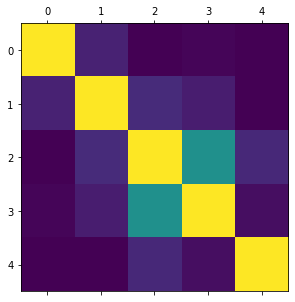

In [72]:
plt.matshow(df_sub[['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean']].corr())
plt.show()

In [83]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,log_best,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,0.0010
No. Observations:,126548,R-squared (Within):,0.0003
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.0005
Time:,22:20:03,Log-likelihood,-3673.6
Cov. Estimator:,Clustered,,
,,F-statistic:,6.2405
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.7503


In [69]:
df_sub[df_sub['Raw'] == 1].shape

(121869, 33)

In [70]:
df_sub[df_sub['Submitted'] == 1].shape

(4224, 33)

In [66]:
X = df_sub.loc[:,['Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2536
Estimator:,PanelOLS,R-squared (Between):,0.7249
No. Observations:,126548,R-squared (Within):,0.2578
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5265
Time:,22:07:20,Log-likelihood,-1.454e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.149e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1848.2


In [68]:
X = df_sub.loc[:,['Raw']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,-0.1356
No. Observations:,126548,R-squared (Within):,0.0003
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0694
Time:,22:09:08,Log-likelihood,-4.371e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,38.815
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,35.303


In [12]:
df_sub

person_mean  child_mean  male_mean  adult_mean  youth_mean  \
gid    month_id                                                               
177569 348               3.0         0.0        3.4         2.8         0.0   
       357               3.0         0.0        1.4         1.2         0.0   
       334               1.6         0.0        1.6         2.4         0.0   
179003 311               2.8         0.0        1.4         1.8         0.0   
       311               1.8         0.0        1.4         1.8         0.0   
...                      ...         ...        ...         ...         ...   
179009 289               2.8         1.5        1.8         2.4         1.0   
       289               0.6         0.0        0.2         0.2         0.0   
       289               2.0         0.0        2.0         1.8         0.0   
       289               4.8         1.5        4.0         4.6         0.5   
       289               6.8         0.5        4.2         5.2         0.5   

                 falgIRQ_mean  female_mean  religiousGarmentFemale_mean  \
gid    month_id                                                           
177569 348                0.0          0.0                          0.0   
       357                0.0          0.0                          0.0   
       334                0.0          0.0                          0.0   
179003 311                0.8          0.0                          0.0   
       311                0.0          0.5                          0.0   
...                       ...          ...                          ...   
179009 289                0.0          0.5                          0.0   
       289                0.0          0.0                          0.0   
       289                0.0          1.0                          0.0   
       289                0.0          0.5                          0.0   
       289                0.0          0.5                          0.0   

                 uniformed_mean  firearm_mean  ...  ttime_mean  log_best  \
gid    month_id                                ...                         
177569 348                  0.2           0.0  ...    58.67639  1.791759   
       357                  2.6           0.0  ...    58.67639  1.791759   
       334                  0.6           0.0  ...    58.67639  3.367296   
179003 311                  2.4           0.0  ...   415.26140  4.941642   
       311                  0.0           0.0  ...   415.26140  4.941642   
...                         ...           ...  ...         ...       ...   
179009 289                  0.0           0.2  ...   168.32170  0.000000   
       289                  0.6           0.0  ...   168.32170  0.000000   
       289                  0.4           0.0  ...   168.32170  0.000000   
       289                  0.0           0.0  ...   168.32170  0.000000   
       289                  4.2           1.0  ...   168.32170  0.000000   

                      tce      tsce  Published  Raw  Submitted  intPubBest  \
gid    month_id                                                              
177569 348       1.956879  1.051318          0    1          0         0.0   
       357       2.914739  1.355943          0    1          0         0.0   
       334       3.367234  1.978720          0    1          0         0.0   
179003 311       3.018411  1.516200          0    1          0         0.0   
       311       3.018411  1.516200          0    1          0         0.0   
...                   ...       ...        ...  ...        ...         ...   
179009 289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   

         

In [18]:
bodies_df_exposure['gid'].unique().shape[0] 

23

In [17]:
bodies_df_exposure['gid'].unique().shape[0] * bodies_df_exposure['month_id'].unique().shape[0]

1150

In [21]:
bodies_df_exposure['month_id'].unique()

array([348, 357, 334, 311, 316, 349, 326, 281, 322, 324, 333, 314, 306,
       315, 312, 307, 303, 331, 304, 356, 308, 313, 330, 321, 288, 358,
       336, 280, 332, 279, 310, 305, 325, 289, 335, 359, 350, 338, 292,
       320, 345, 352, 241, 361, 300, 294, 257, 282, 327, 299])

# Old ish

# NOTES:


RQ:
- To what extent does the distribution of content in the images, differs across publication status.
 
- To What extent does the distribution of content in the images corrolate with the magnitude/exposure of conflict 


In [3]:
# pre

list_of_features_mean = [feature for feature in bodies_df_exposure.columns if 'mean' in feature] 

df_sub = bodies_df_exposure[list_of_features_mean + ['log_best', 'tce', 'tsce', 'publication', 'month_id', 'gid']].copy()
df_sub = df_sub[df_sub['person_mean'] != 0] # no people, no entry
df_sub[['Published', 'Raw', 'Submitted']] = pd.get_dummies(df_sub[['publication']])
df_sub.drop(columns= 'publication', inplace= True)
df_sub.dropna(inplace= True)
df_sub.set_index(['gid', 'month_id'], inplace = True)
df_sub['intPubBest'] = df_sub['Published'] * df_sub['log_best']
df_sub['intPubTce'] = df_sub['Published'] * df_sub['tce']
df_sub['intPubTsce'] = df_sub['Published'] * df_sub['tsce']


# also drop all with no persons in them

# gender
## Contiues dependents:

$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

Interestingly, the results holds is we have male mean as dependent. I.e. then Published is significantly negativly corrolated with published 


In [4]:
X = df_sub.loc[:,['log_best', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2542
Estimator:,PanelOLS,R-squared (Between):,0.7204
No. Observations:,126548,R-squared (Within):,0.2526
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4840
Time:,13:23:08,Log-likelihood,-1.454e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.078e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.909e+18


$$
male_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [5]:
X = df_sub.loc[:,['log_best', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9647
No. Observations:,126548,R-squared (Within):,0.8762
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.9278
Time:,13:23:11,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.185e+18



$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [6]:
X = df_sub.loc[:,['tce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2545
Estimator:,PanelOLS,R-squared (Between):,0.7171
No. Observations:,126548,R-squared (Within):,0.2624
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5364
Time:,13:23:13,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-8.728e+18


In [7]:
X = df_sub.loc[:,['tce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9604
No. Observations:,126548,R-squared (Within):,0.8762
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.9191
Time:,13:23:15,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,4.593e+18



$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [8]:
X = df_sub.loc[:,['tsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2544
Estimator:,PanelOLS,R-squared (Between):,0.7217
No. Observations:,126548,R-squared (Within):,0.2610
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5315
Time:,13:23:17,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-8.728e+18



$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [9]:
X = df_sub.loc[:,['tsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9609
No. Observations:,126548,R-squared (Within):,0.8763
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.9202
Time:,13:23:19,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.185e+18


$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [10]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3404
Estimator:,PanelOLS,R-squared (Between):,0.9104
No. Observations:,126548,R-squared (Within):,0.3517
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4274
Time:,13:23:21,Log-likelihood,-1.74e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.632e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,4.465e+19


$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [11]:
X = df_sub.loc[:,['female_mean', 'tce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3407
Estimator:,PanelOLS,R-squared (Between):,0.8938
No. Observations:,126548,R-squared (Within):,0.3500
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.3711
Time:,13:23:23,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.634e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,8.726e+19


$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

# with interactions

In [12]:
X = df_sub.loc[:,['log_best', 'intPubBest', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/2099713059.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,female_mean,R-squared:,0.2542
Estimator:,PanelOLS,R-squared (Between):,0.7204
No. Observations:,126548,R-squared (Within):,0.2526
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4839
Time:,13:23:25,Log-likelihood,-1.454e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.078e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.099e+18


In [13]:
X = df_sub.loc[:,['tce', 'intPubTce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/1668388244.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,female_mean,R-squared:,0.2545
Estimator:,PanelOLS,R-squared (Between):,0.7171
No. Observations:,126548,R-squared (Within):,0.2624
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5364
Time:,13:23:28,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.396e+18


In [14]:
X = df_sub.loc[:,['tsce', 'intPubTsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/3023179014.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,female_mean,R-squared:,0.2544
Estimator:,PanelOLS,R-squared (Between):,0.7217
No. Observations:,126548,R-squared (Within):,0.2610
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5315
Time:,13:23:30,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,2.889e+18


In [15]:
X = df_sub.loc[:,['female_mean', 'log_best', 'intPubBest', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/2186205462.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3404
Estimator:,PanelOLS,R-squared (Between):,0.9104
No. Observations:,126548,R-squared (Within):,0.3517
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4274
Time:,13:23:33,Log-likelihood,-1.74e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.632e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-3.426e+19


In [16]:
X = df_sub.loc[:,['female_mean', 'tce', 'intPubTce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/1318747554.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3407
Estimator:,PanelOLS,R-squared (Between):,0.8938
No. Observations:,126548,R-squared (Within):,0.3500
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.3711
Time:,13:23:35,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.634e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-5.157e+19


In [17]:
X = df_sub.loc[:,['female_mean', 'tsce', 'intPubTsce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/3981241453.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3406
Estimator:,PanelOLS,R-squared (Between):,0.8821
No. Observations:,126548,R-squared (Within):,0.3485
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.3595
Time:,13:23:38,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.633e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,7.339e+19


### Binary dependent (linar probability model)

$$
binaryFemale_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
binaryFeligiousGarments_{it} =  \gamma_{i} + \alpha_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [18]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = (df_sub.loc[:, 'female_mean'] > 0).astype(int)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.0758
Estimator:,PanelOLS,R-squared (Between):,0.4731
No. Observations:,126548,R-squared (Within):,0.0772
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.2993
Time:,13:23:41,Log-likelihood,-8.038e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2593.7
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.646e+17


In [19]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = (df_sub.loc[:, 'religiousGarmentFemale_mean'] > 0).astype(int)

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.2533
Estimator:,PanelOLS,R-squared (Between):,0.8558
No. Observations:,126548,R-squared (Within):,0.2663
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4119
Time:,13:23:43,Log-likelihood,-4.076e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,8579.7
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,2.445e+20


## Logged dependent

$$
logFemale_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
logFeligiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [20]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = np.log(df_sub.loc[:, 'female_mean']+1)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2046
Estimator:,PanelOLS,R-squared (Between):,0.7023
No. Observations:,126548,R-squared (Within):,0.2032
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4531
Time:,13:23:45,Log-likelihood,-5.737e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,8133.4
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,7.965e+19


In [21]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = np.log(df_sub.loc[:, 'religiousGarmentFemale_mean'] + 1)

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3339
Estimator:,PanelOLS,R-squared (Between):,0.9286
No. Observations:,126548,R-squared (Within):,0.3463
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4581
Time:,13:23:48,Log-likelihood,3.722e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.268e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.003e+19


## ratio dependent

$$
ratioFemalePerson_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
ratioFemaleReligiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} + female_{it} \epsilon_{it}  
$$

In [22]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'female_mean']/df_sub.loc[:, 'person_mean']


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,0,R-squared:,0.0070
Estimator:,PanelOLS,R-squared (Between):,-0.1795
No. Observations:,126548,R-squared (Within):,0.0074
Date:,"Mon, Sep 19 2022",R-squared (Overall):,-0.0866
Time:,13:23:50,Log-likelihood,-4.297e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,222.22
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-9.783e+18


In [23]:
df_sub_fem = df_sub[df_sub['female_mean']>0].copy()

X = df_sub_fem.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub_fem.loc[:, 'religiousGarmentFemale_mean']/df_sub_fem.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,0,R-squared:,0.0111
Estimator:,PanelOLS,R-squared (Between):,0.2531
No. Observations:,72153,R-squared (Within):,0.0061
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.1782
Time:,13:23:51,Log-likelihood,-1.576e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,161.68
Entities:,23,P-value,0.0000
Avg Obs:,3137.1,Distribution:,"F(5,72082)"
Min Obs:,0.0000,,
Max Obs:,6.138e+04,F-statistic (robust):,7.842e+19


Conflict
...

In [24]:
X = df_sub.loc[:, list_of_features_mean] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.

In [ ]:
X = df_sub.loc[:, list_of_features_mean] # raw is ref
y = df_sub.loc[:, 'tce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tce,R-squared:,0.0056
Estimator:,PanelOLS,R-squared (Between):,-0.0105
No. Observations:,126548,R-squared (Within):,-0.0003
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.0065
Time:,00:11:30,Log-likelihood,1.443e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,44.391
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(16,126462)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.1840


In [ ]:

X = df_sub.loc[:, list_of_features_mean + ['Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tsce,R-squared:,0.0055
Estimator:,PanelOLS,R-squared (Between):,-0.0058
No. Observations:,126548,R-squared (Within):,-0.0003
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.0053
Time:,00:17:32,Log-likelihood,1.17e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,39.208
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(18,126460)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.6207


In [ ]:

X = df_sub.loc[:, ['religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tsce,R-squared:,0.0004
Estimator:,PanelOLS,R-squared (Between):,0.0013
No. Observations:,126548,R-squared (Within):,0.0003
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.0008
Time:,00:16:36,Log-likelihood,1.167e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,47.474
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.8739


In [ ]:

df_sub['intTsceFemale'] = df_sub.loc[:,'tsce']  * df_sub.loc[:,'female_mean'] 


X = df_sub.loc[:, ['tsce', 'female_mean', 'intTsceFemale']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3402
Estimator:,PanelOLS,R-squared (Between):,0.8813
No. Observations:,126548,R-squared (Within):,0.3476
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.3385
Time:,00:26:38,Log-likelihood,-1.742e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.173e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1710.4


In [ ]:
df_sub_fem = df_sub[df_sub['female_mean']>0].copy()

df_sub_fem['intTsceFemale'] = df_sub_fem.loc[:,'tsce']  * df_sub_fem.loc[:,'female_mean'] 

X = df_sub_fem.loc[:,['female_mean', 'tsce', 'intTsceFemale']] # raw is ref
y = df_sub_fem.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.2802
Estimator:,PanelOLS,R-squared (Between):,0.7057
No. Observations:,72153,R-squared (Within):,0.2747
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.1090
Time:,00:22:59,Log-likelihood,-2.898e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,9355.0
Entities:,23,P-value,0.0000
Avg Obs:,3137.1,Distribution:,"F(3,72084)"
Min Obs:,0.0000,,
Max Obs:,6.138e+04,F-statistic (robust):,1790.7


In [ ]:
X = df_sub.loc[:, ['tsce', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9593
No. Observations:,126548,R-squared (Within):,0.8761
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.9168
Time:,01:04:24,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.197e+18


In [ ]:
X = df_sub.loc[:, ['tsce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'person_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,person_mean,R-squared:,0.0012
Estimator:,PanelOLS,R-squared (Between):,-0.2378
No. Observations:,126548,R-squared (Within):,-0.0145
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.5987
Time:,01:09:26,Log-likelihood,-2.696e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,51.782
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.273e+24


In [ ]:
X = df_sub.loc[:, ['tsce', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'militaryVehicle_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,militaryVehicle_mean,R-squared:,0.0063
Estimator:,PanelOLS,R-squared (Between):,-0.0250
No. Observations:,126548,R-squared (Within):,0.0077
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.0267
Time:,01:11:43,Log-likelihood,3.929e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,201.92
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,3.265e+15


In [ ]:
list_of_features_mean

['person_mean',
 'child_mean',
 'male_mean',
 'adult_mean',
 'youth_mean',
 'falgIRQ_mean',
 'female_mean',
 'religiousGarmentFemale_mean',
 'uniformed_mean',
 'firearm_mean',
 'flagUS_mean',
 'bloodedArea_mean',
 'militaryVehicle_mean',
 'hostage_mean',
 'casualty_mean',
 'elderly_mean']

In [ ]:
X = df_sub.loc[:, ['female_mean', 'religiousGarmentFemale_mean', 'person_mean', 'male_mean']] # raw is ref
y = df_sub.loc[:, 'Published']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,Published,R-squared:,0.0017
Estimator:,PanelOLS,R-squared (Between):,-2.0649
No. Observations:,126548,R-squared (Within):,0.0027
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.0008
Time:,00:52:35,Log-likelihood,1.852e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,43.099
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.6569


# old

In [ ]:

fitted_dict = dict()

for i in list_of_features_mean:

    X = df_sub.loc[:,['log_best', 'Published', 'Submitted']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True)

    fitted_dict[i] = m.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
fitted_dict

LinAlgError: Singular matrix

In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3554
Estimator:,PanelOLS,R-squared (Between):,0.9075
No. Observations:,152188,R-squared (Within):,0.3676
Date:,"Mon, Jun 27 2022",R-squared (Overall):,0.4309
Time:,10:48:20,Log-likelihood,-7166.9
Cov. Estimator:,Clustered,,
,,F-statistic:,2.097e+04
Entities:,23,P-value,0.0000
Avg Obs:,6616.9,Distribution:,"F(4,152112)"
Min Obs:,2.0000,,
Max Obs:,1.234e+05,F-statistic (robust):,6.135e+21


In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3554
Estimator:,PanelOLS,R-squared (Between):,0.9075
No. Observations:,152188,R-squared (Within):,0.3676
Date:,"Mon, Jun 27 2022",R-squared (Overall):,0.4309
Time:,10:24:07,Log-likelihood,-7166.9
Cov. Estimator:,Clustered,,
,,F-statistic:,2.097e+04
Entities:,23,P-value,0.0000
Avg Obs:,6616.9,Distribution:,"F(4,152112)"
Min Obs:,2.0000,,
Max Obs:,1.234e+05,F-statistic (robust):,6.135e+21
